In [0]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
df = pd.read_csv('train.csv')

df.head(5)

In [0]:
def preprocess_image(image_path, desired_size=96):
    im = cv2.imread(image_path)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (desired_size, desired_size))
    im = cv2.addWeighted(im, 4, cv2.blur(im, ksize=(10,10)), -4, 128)
    return im

In [0]:
N = df.shape[0]
X = np.empty((N, 96, 96, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(df['id_code'])):
    X[i, :, :, :] = preprocess_image(
        f'train_images/{image_id}.png'
    )

100%|██████████| 3662/3662 [05:08<00:00, 11.89it/s]


In [0]:
y = df['diagnosis']
y.head(10)

0    2
1    4
2    1
3    0
4    0
5    4
6    0
7    2
8    2
9    1
Name: diagnosis, dtype: int64

In [0]:
from keras.utils import np_utils
y1 = np_utils.to_categorical(y)
print('The shape of y1 is:', y1.shape)
num_classes = y1.shape[1]
y1[:10]

The shape of y1 is: (3662, 5)


array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2, random_state=42)
print('The shape of X_train is:', X_train.shape)
print('The shape of y_train is:', y_train.shape)
print('The shape of X_test is:', X_test.shape)
print('The shape of y_test is:', y_test.shape)

The shape of X_train is: (2929, 96, 96, 3)
The shape of y_train is: (2929, 5)
The shape of X_test is: (733, 96, 96, 3)
The shape of y_test is: (733, 5)


In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, GaussianNoise, GaussianDropout
from keras.layers import Flatten, BatchNormalization
from keras.layers.convolutional import Conv2D, SeparableConv2D

from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras import regularizers

in_size = (96,96,3)

In [0]:
# Import necessary packages
import argparse

# Import necessary components to build LeNet
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2

def alexnet_model(img_shape=in_size, n_classes=num_classes, l2_reg=0.,
    weights=None):

    # Initialize model
    alexnet = Sequential()

    # Layer 1
    alexnet.add(Conv2D(96, (11, 11), input_shape=img_shape,
        padding='same', kernel_regularizer=l2(l2_reg)))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    alexnet.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 2
    alexnet.add(Conv2D(256, (5, 5), padding='same'))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    alexnet.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 3
    alexnet.add(ZeroPadding2D((1, 1)))
    alexnet.add(Conv2D(512, (3, 3), padding='same'))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    alexnet.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 4
    alexnet.add(ZeroPadding2D((1, 1)))
    alexnet.add(Conv2D(1024, (3, 3), padding='same'))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))

    # Layer 5
    alexnet.add(ZeroPadding2D((1, 1)))
    alexnet.add(Conv2D(1024, (3, 3), padding='same'))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    alexnet.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 6
    alexnet.add(Flatten())
    alexnet.add(Dense(3072))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    alexnet.add(Dropout(0.5))

    # Layer 7
    alexnet.add(Dense(4096))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    alexnet.add(Dropout(0.5))

    # Layer 8
    alexnet.add(Dense(n_classes))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('softmax'))

    if weights is not None:
        alexnet.load_weights(weights)
    return alexnet

In [0]:
model = alexnet_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 96)        34944     
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 96)        384       
_________________________________________________________________
activation_1 (Activation)    (None, 96, 96, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 256)       614656    
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 256)       1024      
_________________________________________________________________
activation_2 (Activation)    (None, 48, 48, 256)      

In [0]:
from sklearn.metrics import cohen_kappa_score, accuracy_score
from keras.callbacks import Callback, ModelCheckpoint

class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_pred = self.model.predict(X_val)

        _val_kappa = cohen_kappa_score(
            y_val.argmax(axis=1), 
            y_pred.argmax(axis=1), 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")

        return

In [0]:
from keras.optimizers import Adam

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.00005), metrics=['accuracy'])

In [0]:
BATCH_SIZE = 32

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.10,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Using original generator
data_generator = create_datagen().flow(X_train, y_train, batch_size=BATCH_SIZE)

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

earlystopping = EarlyStopping(patience=5, verbose=1)

kappa_metrics = Metrics()

checkpoint = ModelCheckpoint(
    'model_alexnet_aptos.h5', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

In [0]:
history = model.fit_generator(
    data_generator,
    steps_per_epoch=X_train.shape[0] / BATCH_SIZE,
    epochs=25,
    validation_data=(X_test, y_test),
    callbacks=[earlystopping, checkpoint, kappa_metrics]
)

Epoch 1/5
92/91 [==============================] - 1428s 16s/step - loss: 1.1588 - accuracy: 0.5910 - val_loss: 1.1978 - val_accuracy: 0.5293
val_kappa: 0.5878
Epoch 2/5
92/91 [==============================] - 1434s 16s/step - loss: 1.0728 - accuracy: 0.6333 - val_loss: 1.0464 - val_accuracy: 0.6903
val_kappa: 0.5967
Epoch 3/5
92/91 [==============================] - 1433s 16s/step - loss: 1.0512 - accuracy: 0.6473 - val_loss: 1.0295 - val_accuracy: 0.6971
val_kappa: 0.5558
Epoch 4/5
92/91 [==============================] - 1476s 16s/step - loss: 1.0213 - accuracy: 0.6705 - val_loss: 1.0795 - val_accuracy: 0.6044
val_kappa: 0.6780
Epoch 5/5
92/91 [==============================] - 1472s 16s/step - loss: 1.0195 - accuracy: 0.6664 - val_loss: 1.0629 - val_accuracy: 0.6398
val_kappa: 0.3261


In [0]:
y_pred = model.predict(X_train)

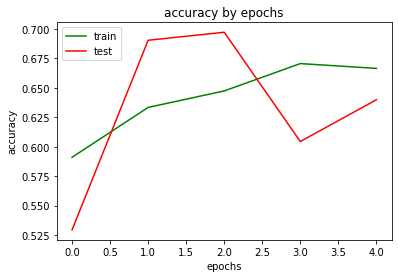

In [0]:
from matplotlib import pyplot as plt

fig = plt.plot(history.history["accuracy"],label = "train", color='green')
plt.plot(history.history["val_accuracy"],label = "test", color='red')
plt.legend(loc='upper left')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("accuracy by epochs")
plt.show()

In [0]:
test_df = pd.read_csv('sample_submission.csv')

In [0]:
N = test_df.shape[0]
x_test = np.empty((N, 96, 96, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(test_df['id_code'])):
    x_test[i, :, :, :] = preprocess_image(
        f'test_images/{image_id}.png'
    )

In [0]:
model.load_weights('model_alexnet_aptos.h5')
y_test = model.predict(x_test, verbose=2)

test_df['diagnosis'] = y_test.argmax(axis=1)
print(test_df.head(10))

test_df.to_csv('submission.csv',index=False)

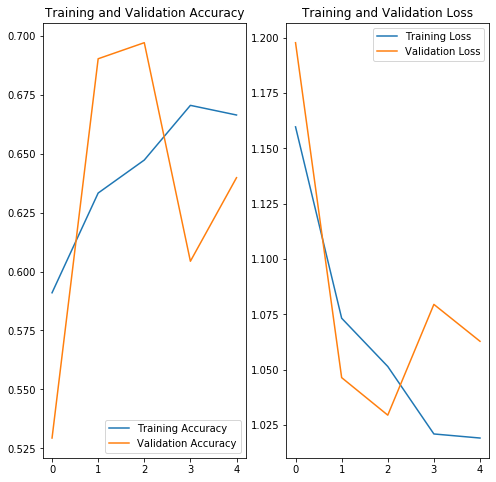

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()